In [254]:
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import SchemDraw as SchemDraw
import SchemDraw.elements as SchemDrawElement
import numpy as np
import ahkab
from ahkab import circuit, printing, time_functions
import pylab as plt

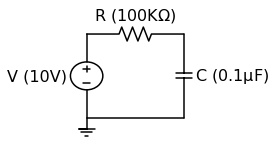

In [255]:
esquematico = SchemDraw.Drawing(unit=3)
V = esquematico.add(SchemDrawElement.SOURCE_V, label='V (10V)')
R = esquematico.add(SchemDrawElement.RES, d='right', label='R (100K$\Omega$)')
esquematico.add(SchemDrawElement.CAP, d='down', botlabel='C (0.1$\mu$F)')
esquematico.add(SchemDrawElement.LINE, to=V.start)
esquematico.add(SchemDrawElement.GND)
esquematico.draw()
esquematico.save('schematic.jpg')

In [20]:
circuito = circuit.Circuit(title="Circuito")
gnd = circuito.get_ground_node()
circuito.add_resistor("R", n1="1", n2="2", value=1000)
circuito.add_capacitor("C", n1="2", n2=gnd, value=1e-6)
circuito.add_vsource("V", n1=gnd, n2="1", dc_value=10)

In [19]:
print(circuito.nodes_dict)
print(circuito)

{0: '0', '0': 0, '1': 1, 1: '1', 2: '2', '2': 2}

In [5]:
tran_analysis = ahkab.new_tran(tstart=0, tstop=1.2e-3, tstep=1e-6, x0=None)
r = ahkab.run(circuito, an_list=[tran_analysis])

Text(0.5, 0, 'Time [s]')

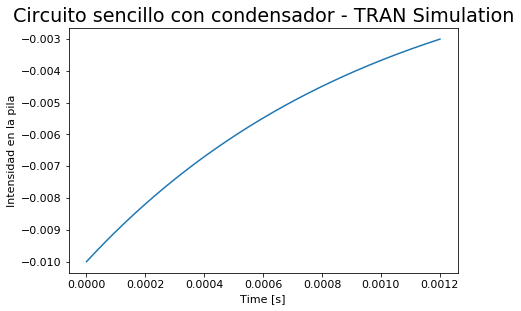

In [6]:
fig = plt.figure()
plt.title(circuito.title + " - TRAN Simulation")
plt.plot(r['tran']['T'], r['tran']['I(V)'], label="Voltaje en el condensador")
plt.ylabel('Intensidad en la pila')
plt.xlabel('Time [s]')

In [ ]:
mycir = ahkab.circuit.Circuit(title="Butterworth Example circuit")
voltage_step = time_functions.pulse(v1=0, v2=1, td=500e-9, tr=1e-12, pw=1, tf=1e-12, per=2)
#mycir.add_vsource("V1", n1="n1", n2=gnd, dc_value=5, ac_value=1, function=voltage_step)
#mycir.add_isource('Isource', 'nA', 'nD', dc_value=1)
#mycir.add_resistor('Rad', 'nA', 'nD', value=5)
#mycir.add_vsource('Vgnd', mycir.gnd, 'nC', dc_value=0)
#tp1 = mycir.create_node('tp1')
#out = mycir.create_node('out')
gnd = mycir.get_ground_node()
print(mycir)

In [250]:
import ahkab
from tempfile import NamedTemporaryFile

netlist = """
.title voltage divider
v1 vcc 0 type=vdc vdc=375 vac=1
r1 vcc tp1 30e6
r2 tp1 0 10e4
*r3 tp1 2 10e4
*r4 2 tp2 10e3
*r5 0 tp2 10e3

.dc tp1 0 2 0.05 
*vammeter vcc tp1 type=vdc vdc=0
"""

tp = NamedTemporaryFile(mode='w+', delete=False)
tp.write(netlist)
tp.close()

cir = ahkab.netlist_parser.parse_circuit(tp.name)[0]

op_analysis = ahkab.new_op(verbose=True)
ac_analysis = ahkab.new_ac(start=1e3, stop=1e5, points=100, verbose=True)
#dc_analysis = ahkab.new_dc(source=cir, start=1e3, stop=1e5, points=100, verbose=True)
tran_analysis = ahkab.new_tran(tstart=0, tstop=1.2e-3, tstep=1e-4, x0=None, verbose=True)
r = ahkab.run(cir, an_list=[op_analysis, ac_analysis, tran_analysis])

print(r.keys())
print(r['op'].keys())
print(r['ac'].keys())
print(r['tran'].keys())

Calculating guess: skipped. (linear circuit)
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting AC analysis: 
done.


dict_keys(['op', 'ac', 'tran'])

['VVCC', 'VTP1', 'I(V1)']

['f', 'Vvcc', 'Vtp1', 'I(V1)']

['T', 'VVCC', 'VTP1', 'I(V1)']

In [251]:
# op = r['op'].results
Vtp1_op = r['op']['VTP1'][0][0]
print(Vtp1_op)

Vtp1_ac = r['tran']['I(V1)'][0]
print(Vtp1_ac)

#Itp1_op = r['op']['I(VAMMETER)'][0][0]
#print(Itp1_op)

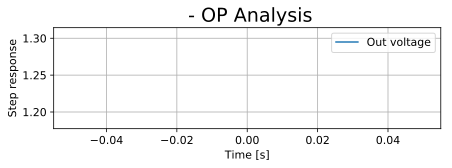

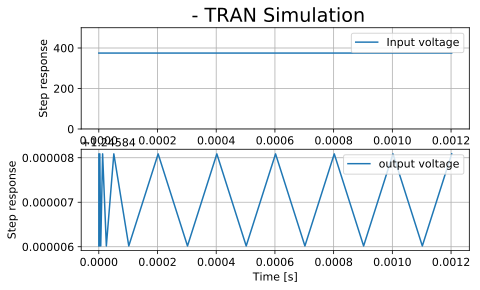

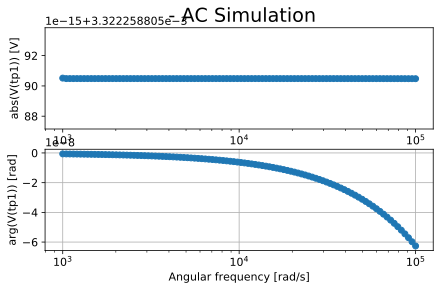

In [238]:
import pylab as plt
import numpy as np

fig = plt.figure()
plt.subplot(211)
plt.title(cir.title + " - OP Analysis")
plt.plot(r['op']['VTP1'], label="Out voltage")
plt.legend()
plt.grid(True)
plt.ylabel('Step response')
plt.xlabel('Time [s]')
plt.show()

fig = plt.figure()
plt.subplot(211)
plt.title(cir.title + " - TRAN Simulation")
plt.plot(r['tran']['T'], r['tran']['VVCC'], label="Input voltage")
plt.legend()
plt.grid(True)
plt.ylim([0,500])
plt.ylabel('Step response')
plt.xlabel('Time [s]')

plt.subplot(212)
plt.plot(r['tran']['T'], r['tran']['VTP1'], label="output voltage")
plt.legend()
plt.grid(True)
plt.ylabel('Step response')
plt.xlabel('Time [s]')
plt.show()
fig.savefig('tran_plot.png')

fig2 = plt.figure()
plt.subplot(211)
plt.semilogx(r['ac']['f'], np.abs(r['ac']['Vtp1']), 'o-')
plt.ylabel('abs(V(tp1)) [V]')
plt.title(cir.title + " - AC Simulation")
plt.subplot(212)
plt.grid(True)
plt.semilogx(r['ac']['f'], np.angle(r['ac']['Vtp1']), 'o-')
plt.xlabel('Angular frequency [rad/s]')
plt.ylabel('arg(V(tp1)) [rad]')
fig2.savefig('ac_plot.png')
plt.show()

In [ ]:
import numpy as np
import scipy, scipy.interpolate

# Normalize the output to the low frequency value and convert to array
norm_out = np.abs(r['ac']['Vn4'])/np.abs(r['ac']['Vn4']).max()
# Convert to dB
norm_out_db = 20*np.log10(norm_out)
# Convert angular frequencies to Hz and convert matrix to array
frequencies = r['ac']['w']/2/np.pi
# call scipy to interpolate
norm_out_db_interpolated = scipy.interpolate.interp1d(frequencies, norm_out_db)

print "Maximum attenuation in the pass band (0-%g Hz) is %g dB" % \
(2e3, -1.0*norm_out_db_interpolated(2e3))
print "Minimum attenuation in the stop band (%g Hz - Inf) is %g dB" % \
(6.5e3, -1.0*norm_out_db_interpolated(6.5e3))